In [1]:
import pandas as pd
import os
import csv
import requests
import json

from math import pi, asin, sqrt, cos, sin
import numpy as np

from datetime import datetime, timedelta

from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
# ********** DEFINIZIONE FUNZIONI
def get_coords_here(api, search, app_id, app_code):
    query = {'searchtext': search,
             'app_id': app_id,
             'app_code': app_code,
             'format': 'json'}
    r = requests.get(api,query)
    return r

def geocoding(luogo, provincia):
    lat = ''
    lon = ''
    luogo = str(luogo).strip().strip(',')
    if luogo not in ['nan', 'VIA', 'MILANO', 'IGNOTO', 'IGNOTA','LUOGO NON INDICATO', 'X']:
        luogo = luogo+', '+provincia
        try:
            r = get_coords_here(api_here, luogo, appId, appCode)
            d = json.loads(r.text)['Response']['View'][0]['Result'][0]['Location']
            lat = d['NavigationPosition'][0]['Latitude']
            lon = d['NavigationPosition'][0]['Longitude']
            print('trovato', luogo)
        except: # se la risposta è vuota, la creazione di d dà errore
            print('    {}: SCONOSCIUTO'.format(luogo))  # se r == []
            pass
    else:
        print('skippato', luogo)
        pass
    return lat, lon

api_here = 'https://geocoder.api.here.com/6.2/geocode.json'
appId = 'WwgQJ8pg3ExUN9PRCyB7'  # MAX 250K RICHIESTE AL MESE!
appCode = 'Uenh83ajLVxXvtSOiS7SZQ'

def inverti_data(data):
    l = data.split('/')
    return '-'.join([l[2],l[1],l[0]])

def completa_secondi(secondo):
    if '.' not in secondo:
        secondo = secondo+'.0000'
    else:
        secondo = secondo.split('.')
        n = len(secondo[1])
        for i in range(4-n):
            secondo[1] += '0'
        secondo = secondo[0]+'.'+secondo[1]
    return secondo

def earth_distance(lat_lng1, lat_lng2):  # da notebook master big data
    if not lat_lng1[0]:
        return
    lat1, lng1 = [float(l)*pi/180 for l in lat_lng1]
    lat2, lng2 = [float(l)*pi/180 for l in lat_lng2]
    dlat, dlng = lat1-lat2, lng1-lng2
    ds = 2 * asin(sqrt(sin(dlat/2.0) ** 2 + cos(lat1) * cos(lat2) * sin(dlng/2.0) ** 2))
    return 6371.01 * ds  # spherical earth...

### Crea dataframe dei crash abbinati con il voucher e contractId

In [2]:
sinistritemp = pd.read_csv('sinistri_MOD_MANUALE.csv', delimiter=';')
sinistritemp['targa'] = sinistritemp['COD_TARGA_TELAIO']
#sinistritemp = sinistritemp[sinistritemp['IND_STATO_DANNO']==0]
del sinistritemp['Unnamed: 13']
#sinistritemp = sinistritemp.dropna()
sinistritemp.head()

,COD_MULTICOMPAGNIA,COD_AGENZIA,DAT_ESER_RUBRICAZ,COD_DANNO,RESP_CIVILE,DAT_AVVENIM_DANNO,DES_LUOGO_DANNO,COD_PROVINCIA,COD_DANNO.1,COD_CONTRATTO,COD_TARGA_TELAIO,IND_STATO_DANNO,DES_STATO_DANNO,targa
0,5.0,59.0,2018.0,4.0,1.0,06/01/2018 00:00,VIA IGNOTA,MI,4.0,28303218.0,FF203PF,2.0,CHIUSO,FF203PF
1,5.0,59.0,2018.0,18.0,1.0,21/01/2018 00:00,MILANO,MI,18.0,28303218.0,FF135VA,2.0,CHIUSO,FF135VA
2,5.0,59.0,2018.0,26.0,1.0,05/02/2018 16:30,CSO 22 MARZO 29,MI,26.0,28303218.0,FM589BK,2.0,CHIUSO,FM589BK
3,5.0,59.0,2018.0,27.0,1.0,10/01/2018 00:40,SANTA MARGHERITA PROTASO,MI,27.0,28303218.0,FF186PG,2.0,CHIUSO,FF186PG
4,5.0,59.0,2018.0,28.0,1.0,02/02/2018 12:35,PZZA XXV APRILE,MI,28.0,28303218.0,FM533BK,2.0,CHIUSO,FM533BK


In [3]:
len(sinistritemp)

266

In [4]:
targhe = pd.read_csv('targa2voucher2.csv', delimiter=';')
targhe['contractid'] = targhe.contractid.astype('str')
targhe.head()

,newvoucherid,contractid,targa
0,46504,38861,DE558MK
1,132581,122354,FG318ZK
2,284133,270876,EY631ZW
3,290128,263601,EZ313RE
4,385453,244737,FM733BJ


In [6]:
sinistri = pd.merge(sinistritemp, targhe, on='targa', how='left')
sinistri = sinistri[['DAT_AVVENIM_DANNO','DES_LUOGO_DANNO','COD_PROVINCIA', 'contractid', 'newvoucherid']]#,'targa']]
sinistri.head(20)

,DAT_AVVENIM_DANNO,DES_LUOGO_DANNO,COD_PROVINCIA,contractid,newvoucherid
0,06/01/2018 00:00,VIA IGNOTA,MI,NaN,NaN
1,21/01/2018 00:00,MILANO,MI,NaN,NaN
2,05/02/2018 16:30,CSO 22 MARZO 29,MI,257577,385566.0
3,10/01/2018 00:40,SANTA MARGHERITA PROTASO,MI,NaN,NaN
4,02/02/2018 12:35,PZZA XXV APRILE,MI,248267,385462.0
5,28/10/2017 00:00,VIA VIOTTI,MI,NaN,NaN
6,28/01/2018 00:30,PLE MORATTI,MI,264623,385635.0
7,11/02/2018 01:20,VIA BARIDONE 29,MI,249436,385475.0
8,03/01/2018 00:00,VIA QUARANTA 40,MI,NaN,NaN
9,12/02/2018 20:55,VIA TURATI 29,MI,267102,385743.0


In [7]:
sinistri = sinistri.dropna(subset=['contractid'])
sinistri.head()

,DAT_AVVENIM_DANNO,DES_LUOGO_DANNO,COD_PROVINCIA,contractid,newvoucherid
2,05/02/2018 16:30,CSO 22 MARZO 29,MI,257577,385566.0
4,02/02/2018 12:35,PZZA XXV APRILE,MI,248267,385462.0
6,28/01/2018 00:30,PLE MORATTI,MI,264623,385635.0
7,11/02/2018 01:20,VIA BARIDONE 29,MI,249436,385475.0
9,12/02/2018 20:55,VIA TURATI 29,MI,267102,385743.0


In [127]:
len(sinistri)

214

In [128]:
sinistri['data'] = sinistri.apply(lambda r: r['DAT_AVVENIM_DANNO'].split()[0], axis=1)
sinistri['data'] = sinistri.apply(lambda r: inverti_data(r['data']), axis=1)
sinistri['ora'] = sinistri.apply(lambda r: r['DAT_AVVENIM_DANNO'].split()[1], axis=1)
sinistri['voucherId'] = sinistri['contractid'].astype('str')
sinistri['luogo'] = sinistri['DES_LUOGO_DANNO']
sinistri['provincia'] = sinistri['COD_PROVINCIA']

del sinistri['DAT_AVVENIM_DANNO']
del sinistri['contractid']
del sinistri['newvoucherid']
del sinistri['DES_LUOGO_DANNO']
del sinistri['COD_PROVINCIA']

sinistri.head(20)

,data,ora,voucherId,luogo,provincia
2,2018-02-05,16:30,257577,CSO 22 MARZO 29,MI
4,2018-02-02,12:35,248267,PZZA XXV APRILE,MI
6,2018-01-28,00:30,264623,PLE MORATTI,MI
7,2018-02-11,01:20,249436,VIA BARIDONE 29,MI
9,2018-02-12,20:55,267102,VIA TURATI 29,MI
10,2018-03-03,00:00,265948,VIALE FILARETI 29,MI
12,2018-03-11,00:00,248746,VIA CHINOTTO,MI
13,2018-03-08,22:45,263904,VIA NOVARA,MI
14,2018-03-15,20:38,269917,CORSO LODI,MI
15,2018-03-05,00:00,253778,VIA PADOVA 115,MI


In [129]:
sinistri[['lat','lon']] = sinistri.apply(lambda r: pd.Series(geocoding(r['luogo'], r['provincia'])), axis=1)

trovato CSO 22 MARZO 29, MI
trovato CSO 22 MARZO 29, MI
trovato PZZA XXV APRILE, MI
trovato PLE MORATTI, MI
trovato VIA BARIDONE 29, MI
trovato VIA TURATI 29, MI
trovato VIALE FILARETI 29, MI
trovato VIA CHINOTTO, MI
trovato VIA NOVARA, MI
trovato CORSO LODI, MI
trovato VIA PADOVA 115, MI
trovato V.LE E FERMI, MI
skippato IGNOTO
skippato IGNOTO
trovato VIA CENISIO, MI
trovato VIA LOMELLINA 7, MI
trovato VIA MONTI 2, MI
trovato VIA TURATI 40, MI
trovato C.SO ITALIA, MI
skippato MILANO
trovato VIA SARDEGNA, MI
trovato V.LE TOSCANA, MI
trovato VIA BROLETTO, MI
trovato VIA GIACOSA/VIALE MONZA, MI
trovato VIA CASSINIS 66, MI
trovato VIA VARE, MI
trovato VIA LUIGI FIGINI, MI
trovato VIA TIVOLI, MI
trovato VIA ETTORE PONTI, MI
trovato VIA TOLSTOJ 106, MI
trovato VIA LODOVICO IL MORO, MI
skippato VIA
trovato VIA SANT'ERLEMBARDO 3, MI
skippato VIA
skippato VIA
trovato VIA CHIESA, MI
trovato VIALE MONTE GRAPPA, MI
trovato VA CRISPI 6, MI
skippato IGNOTA
trovato VIA COL DI LANA, MI
trovato VIA MO

In [130]:
sinistri.head()

,data,ora,voucherId,luogo,provincia,lat,lon
2,2018-02-05,16:30,257577,CSO 22 MARZO 29,MI,45.4622,9.21405
4,2018-02-02,12:35,248267,PZZA XXV APRILE,MI,45.4807,9.18779
6,2018-01-28,00:30,264623,PLE MORATTI,MI,45.4788,9.12168
7,2018-02-11,01:20,249436,VIA BARIDONE 29,MI,44.7577,8.80369
9,2018-02-12,20:55,267102,VIA TURATI 29,MI,45.477,9.19566


In [131]:
len(sinistri)

214

In [132]:
# elimina sinistri fuori da orizzonte temporale dei crash
# periodo dal 12 febbraio 2018 al 30 ottobre 2018
sinistri['data'] = pd.to_datetime(sinistri['data'], format='%Y-%m-%d')
sinistri = sinistri[sinistri['data']>datetime.strptime('2018-02-12','%Y-%m-%d')]
sinistri = sinistri[sinistri['data']<datetime.strptime('2018-10-30','%Y-%m-%d')]

In [140]:
sinistri.head(10)

AttributeError: '_csv.reader' object has no attribute 'head'

In [134]:
len(sinistri)

189

In [135]:
sinistri.to_csv('sinistri_con_voucher_MOD_MANUALE.csv', sep=';', index=False)

### Abbinamento crash/sinistri

#### Dataframe dei crash e dei relativi file

In [8]:
'''
Crea un dizionario dei file dei crash. La chiave è il crash, il contenuto una lista dei file ACC e POS
'''

directory='D:\\Master\Blob2csv'
file_list = {}

for root,_,files in os.walk(directory):
    for file in files:
        if len(file.split('_'))<8:
            continue
        fileroot = file.strip('.csv').strip('_beforeAugust').strip('_ACC').strip('_POS')
        if fileroot not in file_list:
            file_list[fileroot] = [os.path.join(root,file)]
        else:
            file_list[fileroot].append(os.path.join(root,file))
            
file_list[list(file_list.keys())[0]]

['D:\\Master\\Blob2csv\\ACC\\2018_02_12 10_03_29.000_5_268110_ACC_beforeAugust.csv',
 'D:\\Master\\Blob2csv\\POS\\2018_02_12 10_03_29.000_5_268110_POS_beforeAugust.csv']

In [12]:
len(file_list)

188417

In [69]:
'''
Crea un dataframe riepilogativo dei crash
'''

data = pd.DataFrame()
lista = []
errors = []

for crash in file_list:
    try:
        l = file_list[crash][1].split('\\')[4].split('_')
        if len(l)==10:  # dopo agosto
            when = 'dopoAgosto'
            data = '-'.join([l[0],l[1],l[2]])
            ora = ':'.join([l[3],l[4],completa_secondi(l[5])])
            device = l[7].strip('INFOMOBILITY')
        else:  # prima agosto
            when = 'primaAgosto'
            s = l[2].split(' ')
            data = '-'.join([l[0],l[1],s[0]])
            ora = ':'.join([s[1],l[3],completa_secondi(l[4])])
            device = l[6]
        #acc = pd.read_csv(file_list[crash][0], delimiter=';')
        #a = acc.iloc[59]
       # M = max(a['accX'], a['accY'], a['accZ'])
    except Exception as e:
        print(file_list[crash])
        print(e)
        continue
    dataora = data+' '+ora
    lista.append([device, when, data, ora, dataora, file_list[crash][0], file_list[crash][1]])
    
data = pd.DataFrame(lista, columns=['device', 'periodo', 'data', 'ora', 'timestamp', 'fileACC', 'filePOS'])
#data = data.set_index(['device','data'])
# sposta avanti le ore dei crash in base a ora legale
def OraLegale_and_UTC(giorno, ora):
    giornoora = giorno+' '+ora
    #giorno = datetime.strptime(giorno,'%Y-%m-%d')
    #ora = datetime.strptime(ora,'%H:%M:%S.%f')
    giornoora = datetime.strptime(giornoora,'%Y-%m-%d %H:%M:%S.%f')
    if giornoora>=datetime.strptime('2018-03-25 02:00:00','%Y-%m-%d %H:%M:%S')\
         and giornoora<=datetime.strptime('2018-10-28 03:00:00','%Y-%m-%d %H:%M:%S'):
        delta = timedelta(seconds=3600)
    else:
        delta = timedelta(seconds=7200)
    return str(giornoora + delta)#[11:]

data['timestamp'] = data.apply(lambda r: OraLegale_and_UTC(r['data'],r['ora']), axis=1)
data['ora'] = data.apply(lambda r: str(r['timestamp'])[11:], axis=1)
data['data'] = data.apply(lambda r: str(r['timestamp'])[:10], axis=1)
data.head()

['D:\\Master\\Blob2csv\\ACC\\2018_02_12 16_06_43.000_34751121_267102_RE-ACC_beforeAugust.csv']
list index out of range
['D:\\Master\\Blob2csv\\POS\\2018_03_08 14_08_21_36594671_267094_POS_beforeAugust.csv']
list index out of range
['D:\\Master\\Blob2csv\\POS\\2018_03_08 14_09_25_36594763_269354_POS_beforeAugust.csv']
list index out of range
['D:\\Master\\Blob2csv\\POS\\2018_03_08 14_11_21_36594924_267094_POS_beforeAugust.csv']
list index out of range
['D:\\Master\\Blob2csv\\POS\\2018_03_11 11_44_06_36852347_267096_POS_beforeAugust.csv']
list index out of range
['D:\\Master\\Blob2csv\\POS\\2018_03_11 12_19_16_36855647_267096_POS_beforeAugust.csv']
list index out of range
['D:\\Master\\Blob2csv\\POS\\2018_03_11 12_20_55_36855802_267096_POS_beforeAugust.csv']
list index out of range
['D:\\Master\\Blob2csv\\POS\\2018_03_11 12_22_38_36855946_267096_POS_beforeAugust.csv']
list index out of range
['D:\\Master\\Blob2csv\\POS\\2018_03_14 14_03_27_37124028_248451_POS_beforeAugust.csv']
list inde

,device,periodo,data,ora,timestamp,fileACC,filePOS
0,268110,primaAgosto,2018-02-12,12:03:29,2018-02-12 12:03:29,D:\Master\Blob2csv\ACC\2018_02_12 10_03_29.000...,D:\Master\Blob2csv\POS\2018_02_12 10_03_29.000...
1,266569,primaAgosto,2018-02-12,17:24:22,2018-02-12 17:24:22,D:\Master\Blob2csv\ACC\2018_02_12 15_24_22.000...,D:\Master\Blob2csv\POS\2018_02_12 15_24_22.000...
2,266569,primaAgosto,2018-02-12,17:26:36,2018-02-12 17:26:36,D:\Master\Blob2csv\ACC\2018_02_12 15_26_36.000...,D:\Master\Blob2csv\POS\2018_02_12 15_26_36.000...
3,266569,primaAgosto,2018-02-12,17:30:48,2018-02-12 17:30:48,D:\Master\Blob2csv\ACC\2018_02_12 15_30_48.000...,D:\Master\Blob2csv\POS\2018_02_12 15_30_48.000...
4,264718,primaAgosto,2018-02-12,17:35:13,2018-02-12 17:35:13,D:\Master\Blob2csv\ACC\2018_02_12 15_35_13.000...,D:\Master\Blob2csv\POS\2018_02_12 15_35_13.000...


In [71]:
len(data)

187785

In [72]:
data[data['periodo']=='primaAgosto'].head()

,device,periodo,data,ora,timestamp,fileACC,filePOS
0,268110,primaAgosto,2018-02-12,12:03:29,2018-02-12 12:03:29,D:\Master\Blob2csv\ACC\2018_02_12 10_03_29.000...,D:\Master\Blob2csv\POS\2018_02_12 10_03_29.000...
1,266569,primaAgosto,2018-02-12,17:24:22,2018-02-12 17:24:22,D:\Master\Blob2csv\ACC\2018_02_12 15_24_22.000...,D:\Master\Blob2csv\POS\2018_02_12 15_24_22.000...
2,266569,primaAgosto,2018-02-12,17:26:36,2018-02-12 17:26:36,D:\Master\Blob2csv\ACC\2018_02_12 15_26_36.000...,D:\Master\Blob2csv\POS\2018_02_12 15_26_36.000...
3,266569,primaAgosto,2018-02-12,17:30:48,2018-02-12 17:30:48,D:\Master\Blob2csv\ACC\2018_02_12 15_30_48.000...,D:\Master\Blob2csv\POS\2018_02_12 15_30_48.000...
4,264718,primaAgosto,2018-02-12,17:35:13,2018-02-12 17:35:13,D:\Master\Blob2csv\ACC\2018_02_12 15_35_13.000...,D:\Master\Blob2csv\POS\2018_02_12 15_35_13.000...


In [73]:
data[data['periodo']=='dopoAgosto'].head()

,device,periodo,data,ora,timestamp,fileACC,filePOS
99340,270032,dopoAgosto,2018-08-01,09:59:38,2018-08-01 09:59:38,D:\Master\Blob2csv\ACC\2018_08_01_08_59_38_497...,D:\Master\Blob2csv\POS\2018_08_01_08_59_38_497...
99341,249439,dopoAgosto,2018-08-01,09:59:39,2018-08-01 09:59:39,D:\Master\Blob2csv\ACC\2018_08_01_08_59_39_497...,D:\Master\Blob2csv\POS\2018_08_01_08_59_39_497...
99342,267008,dopoAgosto,2018-08-01,09:59:40,2018-08-01 09:59:40,D:\Master\Blob2csv\ACC\2018_08_01_08_59_40_497...,D:\Master\Blob2csv\POS\2018_08_01_08_59_40_497...
99343,267100,dopoAgosto,2018-08-01,10:04:38,2018-08-01 10:04:38,D:\Master\Blob2csv\ACC\2018_08_01_09_04_38_497...,D:\Master\Blob2csv\POS\2018_08_01_09_04_38_497...
99344,268912,dopoAgosto,2018-08-01,10:04:39,2018-08-01 10:04:39,D:\Master\Blob2csv\ACC\2018_08_01_09_04_39_497...,D:\Master\Blob2csv\POS\2018_08_01_09_04_39_497...


In [54]:
data.groupby(['device','data'])['ora'].count()

device           data      
122354           2018-08-20    1
                 2018-08-21    3
                 2018-08-24    1
                 2018-08-26    1
                 2018-09-05    1
                 2018-09-11    2
                 2018-09-21    1
                 2018-09-29    1
244737           2018-02-16    2
                 2018-02-17    2
                 2018-02-19    1
                 2018-02-21    1
                 2018-02-22    4
                 2018-02-24    1
                 2018-02-25    1
                 2018-02-28    2
                 2018-03-03    2
                 2018-03-06    4
                 2018-03-13    1
                 2018-03-14    2
                 2018-03-17    1
                 2018-03-22    1
                 2018-03-23    2
                 2018-03-29    1
                 2018-04-06    1
                 2018-04-09    1
                 2018-04-11    1
                 2018-04-13    1
                 2018-04-18    1
               

In [216]:
data.groupby(['device','data'])['periodo'].count().median()

2.0

In [217]:
gr = data.groupby(['device','data'])['periodo'].count()

(0, 50)

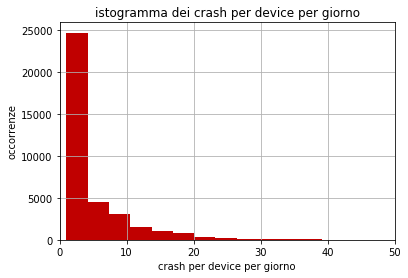

In [218]:
gr.hist(bins=100, color='#c00000')
plt.title('istogramma dei crash per device per giorno')
plt.xlabel('crash per device per giorno')
plt.ylabel('occorrenze')
plt.xlim([0,50])

(0, 50)

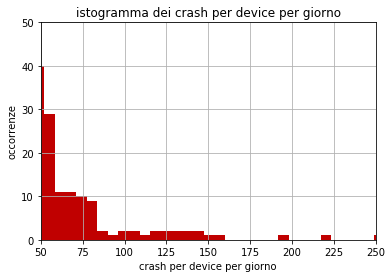

In [219]:
gr.hist(bins=50, color='#c00000')
plt.title('istogramma dei crash per device per giorno')
plt.xlabel('crash per device per giorno')
plt.ylabel('occorrenze')
plt.xlim([50,250])
plt.ylim([0,50])

In [220]:
df = gr.reset_index(name="count")
n = len(df)
print('count==1:', len(df[df['count']==1])/n,'%')
print('count>5:', len(df[df['count']>5])/n,'%')
print('count>=10:', len(df[df['count']>=10])/n,'%')
print('count>50:', len(df[df['count']>50])/n,'%')

count==1: 0.28033495554770127 %
count>5: 0.2897691743019494 %
count>=10: 0.14999592180745494 %
count>50: 0.0026372311791414047 %


In [221]:
print(len(gr))

36781


In [57]:
t = ('264718','2018-02-12')
data.groupby(['device','data']).get_group(t)['periodo'].count()

2

In [238]:
data.head()

,device,periodo,data,ora,timestamp,fileACC,filePOS
0,268110,primaAgosto,2018-02-12,12:03:29,2018-02-12 12:03:29,D:\Master\Blob2csv\ACC\2018_02_12 10_03_29.000...,D:\Master\Blob2csv\POS\2018_02_12 10_03_29.000...
1,266569,primaAgosto,2018-02-12,17:24:22,2018-02-12 17:24:22,D:\Master\Blob2csv\ACC\2018_02_12 15_24_22.000...,D:\Master\Blob2csv\POS\2018_02_12 15_24_22.000...
2,266569,primaAgosto,2018-02-12,17:26:36,2018-02-12 17:26:36,D:\Master\Blob2csv\ACC\2018_02_12 15_26_36.000...,D:\Master\Blob2csv\POS\2018_02_12 15_26_36.000...
3,266569,primaAgosto,2018-02-12,17:30:48,2018-02-12 17:30:48,D:\Master\Blob2csv\ACC\2018_02_12 15_30_48.000...,D:\Master\Blob2csv\POS\2018_02_12 15_30_48.000...
4,264718,primaAgosto,2018-02-12,17:35:13,2018-02-12 17:35:13,D:\Master\Blob2csv\ACC\2018_02_12 15_35_13.000...,D:\Master\Blob2csv\POS\2018_02_12 15_35_13.000...


#### Abbinamento crash/sinistro

In [20]:
def finderLatLon(dataframe):
    dataframe['latitude'] = dataframe['latitude'].interpolate()
    dataframe['longitude'] = dataframe['longitude'].interpolate()
    dat = dataframe.iloc[21]
    return dat['latitude'], dat['longitude']

In [215]:
# sposta avanti le ore dei crash in base a ora legale
#def OraLegale_and_UTC(giorno, ora):
#    giornoora = giorno+' '+ora
    #giorno = datetime.strptime(giorno,'%Y-%m-%d')
    #ora = datetime.strptime(ora,'%H:%M:%S.%f')
#    giornoora = datetime.strptime(giornoora,'%Y-%m-%d %H:%M:%S.%f')
#    if giornoora>=datetime.strptime('2018-03-25 02:00:00','%Y-%m-%d %H:%M:%S')\
#         and giornoora<=datetime.strptime('2018-10-28 03:00:00','%Y-%m-%d %H:%M:%S'):
#        delta = timedelta(seconds=3600)
#    else:
#        delta = timedelta(seconds=7200)
#    return str(giornoora + delta)#[11:]

#data['timestamp'] = data.apply(lambda r: OraLegale_and_UTC(r['data'],r['ora']), axis=1)
#data['ora'] = data.apply(lambda r: str(r['timestamp'])[11:], axis=1)
#data['data'] = data.apply(lambda r: str(r['timestamp'])[:10], axis=1)
#data.head()

In [86]:
def OraLegale_and_UTC(giorno, ora):
    giornoora = giorno+' '+ora
    #giorno = datetime.strptime(giorno,'%Y-%m-%d')
    #ora = datetime.strptime(ora,'%H:%M:%S.%f')
    giornoora = datetime.strptime(giornoora,'%Y-%m-%d %H:%M:%S')
    if giornoora>=datetime.strptime('2018-03-25 02:00:00','%Y-%m-%d %H:%M:%S')\
         and giornoora<=datetime.strptime('2018-10-28 03:00:00','%Y-%m-%d %H:%M:%S'):
        delta = timedelta(seconds=3600)
    else:
        delta = timedelta(seconds=7200)
    return str(giornoora + delta)#[11:]

sinistrif = open('sinistri_con_voucher_MOD_MANUALE.csv','r')
sinistri = csv.reader(sinistrif, delimiter=';')
next(sinistri, None)

# la variabile "data" è il dataframe riepilogativo dei crash. c'è una riga per ogni crash,
# e le colonne comprendono device, data crash, ora crash, timestamp crash, csv dei crash
grouped = data.groupby(['device','data'])

crashAbbinati_list = []
crashAbbinati = pd.DataFrame()

for row in sinistri:
    # le variabili che finiscono per "s" si riferiscono a "sinistro"
    datas = row[0]
    oras = row[1]
    luogos = row[3]
    provincias = row[4]
    lats = row[5]
    lons = row[6]
    delta = 0
    timestamp = datas+' '+oras
    date = datetime.strptime(datas,'%Y-%m-%d')
    hour = datetime.strptime(oras,'%H:%M')
    timestamp = datetime.strptime(timestamp,'%Y-%m-%d %H:%M')
    devices = row[2]#.strip('.0')
    tipo = 'piu_alto'  # inizializza questo tipo di abbinamento: se poi trova intorno 4 ore, lo cambia
    try:
        g = grouped.get_group((devices,datas))  # prende solo i crash per quel device e per quel giorno
        filesAcc = list(g['fileACC'])
        filesPos = list(g['filePOS'])
        timestamp_crash = list(g['timestamp'])
        if oras != '00:00':  # se l'ora NON è un placeholder...
            filesAcc_4ore = []
            filesPos_4ore = []
            for acc,pos,time in zip(filesAcc,filesPos,timestamp_crash):
                diff = np.abs(datetime.strptime(time,'%Y-%m-%d %H:%M:%S')-timestamp)
                if diff<=timedelta(seconds=7200):  # |diff|<=2h
                    filesAcc_4ore.append(acc)
                    filesPos_4ore.append(pos)
            if len(filesAcc_4ore)!=0:  # se c'è almeno un elemento, c'è almeno un crash entro 4 ore!
                filesAcc = filesAcc_4ore
                filesPos = filesPos_4ore
                tipo = 'intorno4ore'
                print('Abbinamento: intorno 4 ore')
        accelerations = []
        for file in filesAcc:
            a = pd.read_csv(file, delimiter=';')
            a['acc'] = np.sqrt(a['accX']**2+a['accY']**2+(a['accZ']-1)**2)
            accelerations.append(max(list(a['acc'])))
            oracrash = a.iloc[59]['datetime'][11:19]
            oracrash = OraLegale_and_UTC(datas,oracrash)[11:19]
        idx = accelerations.index(max(accelerations))
        df = pd.read_csv(filesPos[idx], delimiter=';')
        latc, lonc = finderLatLon(df)

        crashAbbinati_list.append([devices, datas, oras, luogos, provincias, lats, lons,
                                                                        oracrash,
                                                                        filesPos[idx], filesAcc[idx],
                                                                        latc, lonc,
                                                                        tipo])
        print('Abbinato', tipo, datas, oras, devices)
        n_crash.append(g['periodo'].count())
        #ora_crash.append(oras)
        
    except Exception as e:
        print('    Crash non abbinato:', datas, devices, e)
        #crashAbbinati_list.append([devices, datas, oras, luogos, provincias, lats, lons,
        #                                                                '',
        #                                                                '', '',
        #                                                                '', '',
        #                                                                'NON_ABBINATO'])
        
crashAbbinati = pd.DataFrame(crashAbbinati_list, columns=['device', 'dataSinistro', 'oraSinistro', 
                                                          'luogoSinistro', 'provinciaSinistro',
                                                          'latSinistro', 'lonSinistro',
                                                          'oraCrash',
                                                          'filePOS', 'fileACC',
                                                          'latCrash', 'lonCrash',
                                                          'tipoAbbinamento'
                                                         ])

sinistrif.close()

Abbinato piu_alto 2018-03-03 00:00 265948
    Crash non abbinato: 2018-03-11 248746 ('248746', '2018-03-11')
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-08 22:45 263904
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-15 20:38 269917
Abbinato piu_alto 2018-03-05 00:00 253778
Abbinato piu_alto 2018-03-22 00:00 265077
Abbinato piu_alto 2018-04-03 00:00 268524
Abbinato piu_alto 2018-04-09 00:00 264629
    Crash non abbinato: 2018-03-18 268680 ('268680', '2018-03-18')
Abbinato piu_alto 2018-04-14 00:00 252147
    Crash non abbinato: 2018-05-05 262812 ('262812', '2018-05-05')
    Crash non abbinato: 2018-04-04 265948 ('265948', '2018-04-04')
    Crash non abbinato: 2018-04-19 251216 ('251216', '2018-04-19')
Abbinato piu_alto 2018-04-11 00:00 264628
    Crash non abbinato: 2018-05-30 268452 ('268452', '2018-05-30')
    Crash non abbinato: 2018-06-12 252145 ('252145', '2018-06-12')
    Crash non abbinato: 2018-05-30 270002 ('270002', '2018-05-30')
    Crash non abbinato: 20

Abbinato piu_alto 2018-10-23 00:00 264718
Abbinato piu_alto 2018-10-20 00:00 264606
    Crash non abbinato: 2018-10-21 270372 ('270372', '2018-10-21')
    Crash non abbinato: 2018-10-18 267093 ('267093', '2018-10-18')
Abbinato piu_alto 2018-10-27 00:00 257288
    Crash non abbinato: 2018-10-23 270034 ('270034', '2018-10-23')
Abbinato piu_alto 2018-10-24 00:00 252156
    Crash non abbinato: 2018-02-13 275296 ('275296', '2018-02-13')
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-09 11:50 270030
    Crash non abbinato: 2018-03-02 269349 ('269349', '2018-03-02')
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-17 15:35 248199
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-02 08:20 264520
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-11 00:40 262815
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-18 03:00 262810
Abbinato piu_alto 2018-05-01 18:30 251376
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-04-28 13:10 244737
    Crash non abbinato:

In [87]:
crashAbbinati['distanza_km'] = crashAbbinati.apply(lambda r:
                                        earth_distance((r['latSinistro'],
                                                        r['lonSinistro']),
                                                       (r['latCrash'],
                                                        r['lonCrash']))          
                                                  , axis=1)



In [76]:
crashAbbinati.head(2)

,device,dataSinistro,oraSinistro,luogoSinistro,provinciaSinistro,latSinistro,lonSinistro,oraCrash,filePOS,fileACC,latCrash,lonCrash,tipoAbbinamento,distanza_km
0,265948,2018-03-03,00:00,VIALE FILARETI 29,MI,45.5691005,8.9530162,11 2018-03-03 18:49:47.100000 12 2018-03...,D:\Master\Blob2csv\POS\2018_03_03 18_49_52_361...,D:\Master\Blob2csv\ACC\2018_03_03 18_49_52_361...,45.45188,9.19960,piu_alto,23.218392
1,263904,2018-03-08,22:45,VIA NOVARA,MI,45.46937,9.12573,11 2018-03-08 21:32:54.100000 12 2018-03...,D:\Master\Blob2csv\POS\2018_03_08 21_32_59_366...,D:\Master\Blob2csv\ACC\2018_03_08 21_32_59_366...,45.46914,9.12596,intorno4ore,0.031237


In [51]:
targhe = pd.read_csv('targa2voucher.csv', delimiter=';')
targhe['device'] = targhe['contractid'].astype('str')
abb = pd.merge(crashAbbinati, targhe, on='device', how='left')
abb.to_excel('sinistri2crash.xlsx', index=False)
abb.head()

,device,dataSinistro,oraSinistro,luogoSinistro,provinciaSinistro,latSinistro,lonSinistro,oraCrash,filePOS,fileACC,latCrash,lonCrash,tipoAbbinamento,newvoucherid,contractid,targa
0,265948,2018-03-03,00:00,VIALE FILARETI 29,MI,45.5691005,8.9530162,11 2018-03-03 18:49:47.100000 12 2018-03...,D:\Master\Blob2csv\POS\2018_03_03 18_49_52_361...,D:\Master\Blob2csv\ACC\2018_03_03 18_49_52_361...,45.4519,9.1996,ABBINATO,385697,265948,FM869BY
1,248746,2018-03-11,00:00,VIA CHINOTTO,MI,45.46568,9.12722,,,,,,NON_ABBINATO,385473,248746,FM062BR
2,263904,2018-03-08,22:45,VIA NOVARA,MI,45.46937,9.12573,11 2018-03-08 21:32:54.100000 12 2018-03...,D:\Master\Blob2csv\POS\2018_03_08 21_32_59_366...,D:\Master\Blob2csv\ACC\2018_03_08 21_32_59_366...,45.4691,9.12596,ABBINATO,385591,263904,FM597BV
3,269917,2018-03-15,20:38,CORSO LODI,MI,45.4428,9.21824,11 2018-03-15 19:36:11.100000 12 2018-03...,D:\Master\Blob2csv\POS\2018_03_15 19_36_16_372...,D:\Master\Blob2csv\ACC\2018_03_15 19_36_16_372...,45.4407,9.2229,ABBINATO,385865,269917,FM886BY
4,253778,2018-03-05,00:00,VIA PADOVA 115,MI,45.49704,9.23116,11 2018-03-05 14:36:27.100000 12 2018-03...,D:\Master\Blob2csv\POS\2018_03_05 09_05_07.000...,D:\Master\Blob2csv\ACC\2018_03_05 09_05_07.000...,45.5053,9.23774,ABBINATO,385520,253778,FM148BL


In [351]:
crashAbbinati[crashAbbinati['tipoAbbinamento']=='intorno4ore'].head(5)

,device,dataSinistro,oraSinistro,luogoSinistro,provinciaSinistro,latSinistro,lonSinistro,oraCrash,filePOS,fileACC,latCrash,lonCrash,tipoAbbinamento,distanza_km
1,263904,2018-03-08,22:45,VIA NOVARA,MI,45.46937,9.12573,21:32:59,D:\Master\Blob2csv\POS\2018_03_08 21_32_59_366...,D:\Master\Blob2csv\ACC\2018_03_08 21_32_59_366...,45.46914,9.12596,intorno4ore,0.031237
2,269917,2018-03-15,20:38,CORSO LODI,MI,45.4428,9.21824,19:36:16,D:\Master\Blob2csv\POS\2018_03_15 19_36_16_372...,D:\Master\Blob2csv\ACC\2018_03_15 19_36_16_372...,45.44071,9.22290,intorno4ore,0.431495
10,263910,2018-07-19,19:15,VIA TIVOLI,MI,45.47199,9.18348,17:22:20,D:\Master\Blob2csv\POS\2018_07_19 17_22_20_485...,D:\Master\Blob2csv\ACC\2018_07_19 17_22_20_485...,45.46769,9.17873,intorno4ore,0.604826
11,265084,2018-07-25,01:30,VIA TOLSTOJ 106,MI,45.45692,9.1477,23:36:03,D:\Master\Blob2csv\POS\2018_07_24 23_36_03_490...,D:\Master\Blob2csv\ACC\2018_07_24 23_36_03_490...,45.45245,9.15382,intorno4ore,0.689148
14,248203,2018-05-07,06:30,VIA CHIESA,MI,45.57009,8.86413,04:45:57,D:\Master\Blob2csv\POS\2018_05_07 04_45_57_417...,D:\Master\Blob2csv\ACC\2018_05_07 04_45_57_417...,45.52148,9.21333,intorno4ore,27.725655


In [319]:
len(crashAbbinati)

97

In [88]:
#crashAbbinati.to_csv('sinistri2crash_tmp.csv', sep=';', index=False)
crashAbbinati.to_excel('sinistri2crash_MOD_MANUALE_TEMP.xlsx', index=False)

## Studio sinistri con abbinamento potenzialmente corretto

In [62]:
POS = [
    'D:\Master\Blob2csv\POS\\2018_02_17 23_31_25.000_35177882_270370_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_05_20 01_36_28_42901169_256689_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_04_11 03_23_08_39460308_264628_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_10_13_14_57_01_56419504_INFOMOBILITY267639_514_POS.csv',
    'D:\Master\Blob2csv\POS\\2018_07_24 23_36_03_49044612_265084_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_07_21 04_12_03_48681338_264721_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_07_19 17_22_20_48549376_263910_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_03_21 08_46_28_37658392_268527_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_03_15 19_36_16_37225393_269917_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_09_07_00_05_47_53003101_INFOMOBILITY252149_272_POS.csv',
    'D:\Master\Blob2csv\POS\\2018_03_07 07_54_41_36471699_267637_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_03_02 07_19_10_36063563_264520_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_03_04 00_03_17.000_36218145_270033_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_03_10 23_41_25_36822736_262815_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_03_18 01_40_22_37413756_262810_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_10_28_15_52_33_57794457_INFOMOBILITY278357_457_POS.csv',
    'D:\Master\Blob2csv\POS\\2018_03_17 14_24_50_37369846_248199_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_05_11 15_59_48_42144556_268527_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_03_08 21_32_59_36635456_263904_POS_beforeAugust.csv',
    'D:\Master\Blob2csv\POS\\2018_04_12 07_40_57_39561256_248264_POS_beforeAugust.csv' 
]

ACC = [
    'D:\Master\Blob2csv\ACC\\2018_02_17 23_31_25.000_35177882_270370_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_05_20 01_36_28_42901169_256689_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_04_11 03_23_08_39460308_264628_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_10_13_14_57_01_56419504_INFOMOBILITY267639_514_ACC.csv',
    'D:\Master\Blob2csv\ACC\\2018_07_24 23_36_03_49044612_265084_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_07_21 04_12_03_48681338_264721_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_07_19 17_22_20_48549376_263910_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_21 08_46_28_37658392_268527_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_15 19_36_16_37225393_269917_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_09_07_00_05_47_53003101_INFOMOBILITY252149_272_ACC.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_07 07_54_41_36471699_267637_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_02 07_19_10_36063563_264520_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_04 00_03_17.000_36218145_270033_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_10 23_41_25_36822736_262815_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_18 01_40_22_37413756_262810_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_10_28_15_52_33_57794457_INFOMOBILITY278357_457_ACC.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_17 14_24_50_37369846_248199_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_05_11 15_59_48_42144556_268527_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_03_08 21_32_59_36635456_263904_ACC_beforeAugust.csv',
    'D:\Master\Blob2csv\ACC\\2018_04_12 07_40_57_39561256_248264_ACC_beforeAugust.csv' 
]

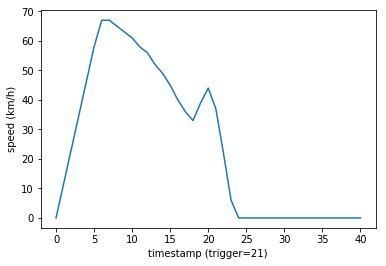

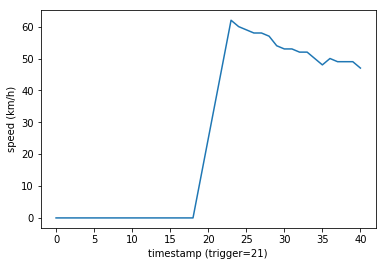

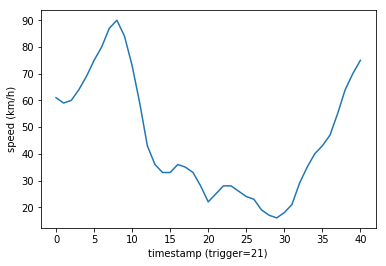

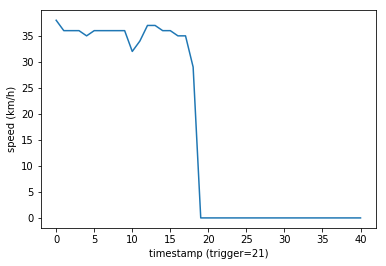

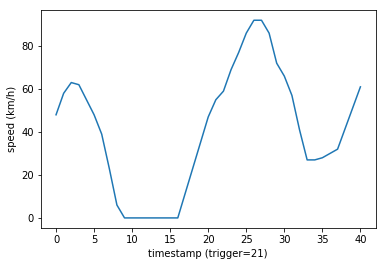

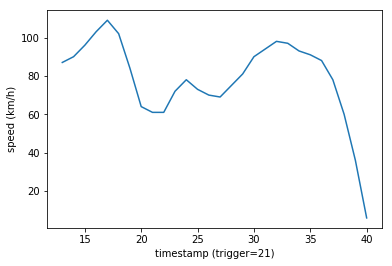

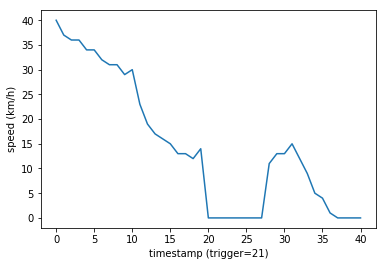

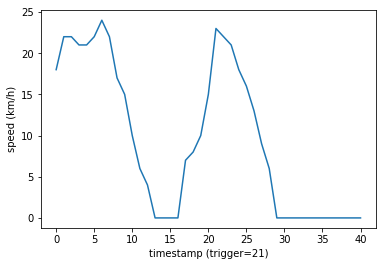

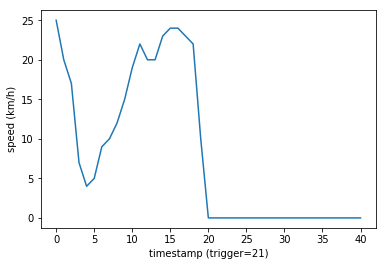

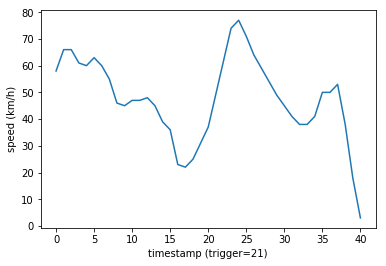

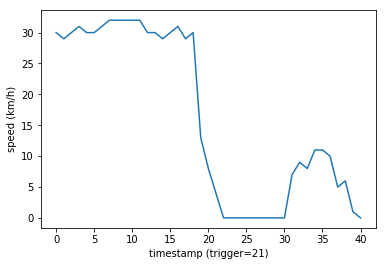

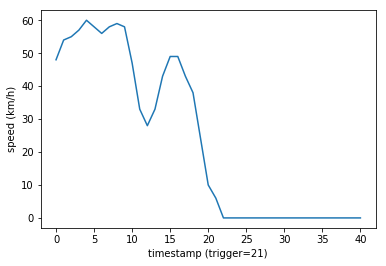

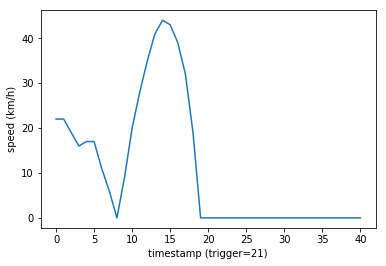

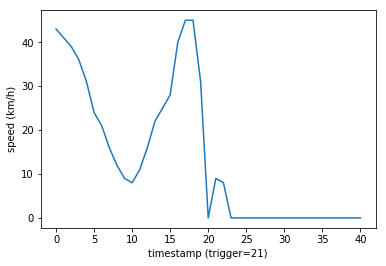

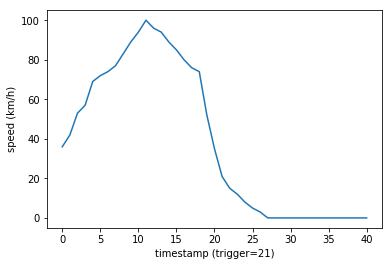

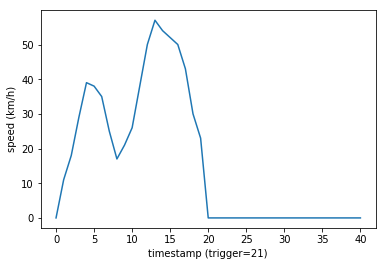

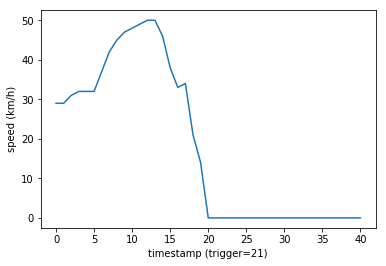

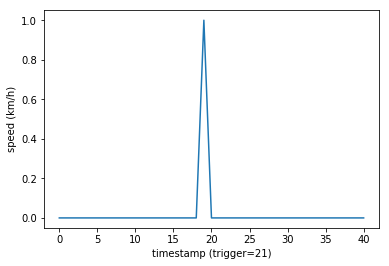

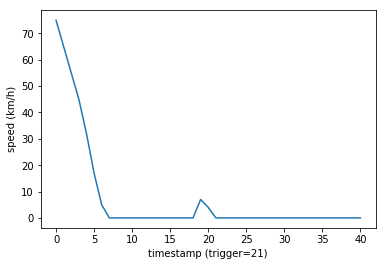

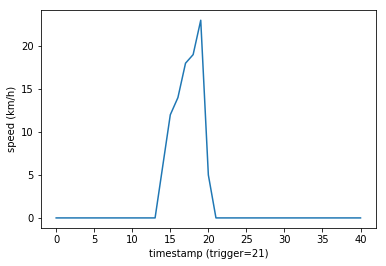

In [61]:
# VELOCITà

def resamplerPos(dataframe):
    dataframe['latitude'] = dataframe['latitude'].interpolate()
    dataframe['longitude'] = dataframe['longitude'].interpolate()
    dataframe['speed'] = dataframe['speed'].interpolate()
    return dataframe

for p in POS:
    df = pd.read_csv(p, delimiter=';')
    df = resamplerPos(df)
    plt.figure()
    plt.plot(df.speed)
    plt.xlabel('timestamp (trigger=21)')
    plt.ylabel('speed (km/h)')

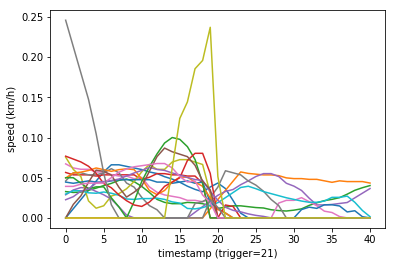

In [68]:
for p in POS:
    if p == 'D:\Master\Blob2csv\POS\\2018_05_11 15_59_48_42144556_268527_POS_beforeAugust.csv':
        continue
    df = pd.read_csv(p, delimiter=';')
    df = resamplerPos(df)
   # plt.figure()
    plt.plot(df.speed/sum(df.speed))
    plt.xlabel('timestamp (trigger=21)')
    plt.ylabel('speed (km/h)')

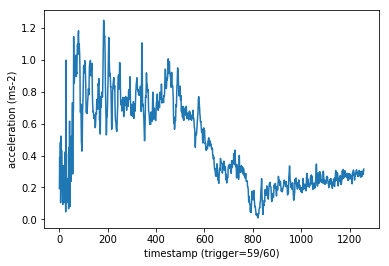

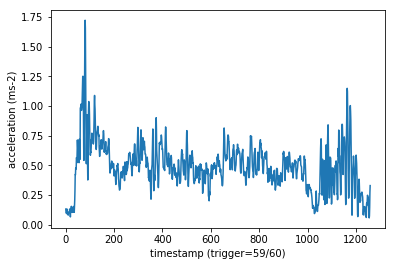

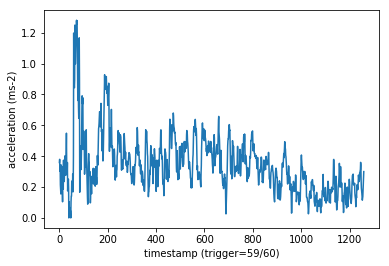

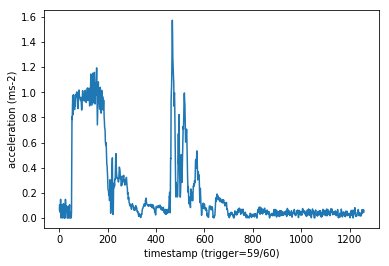

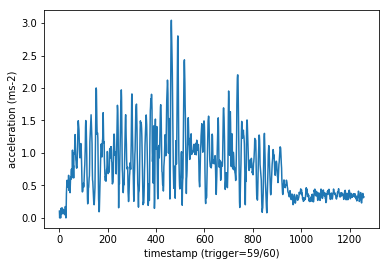

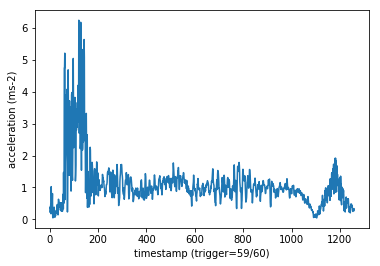

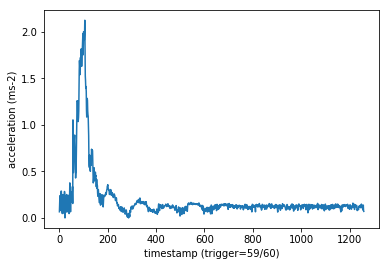

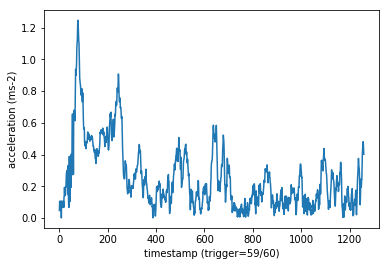

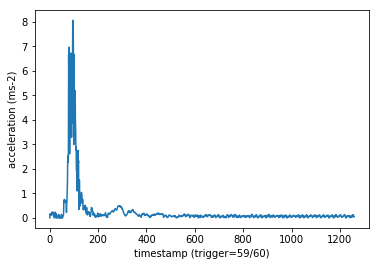

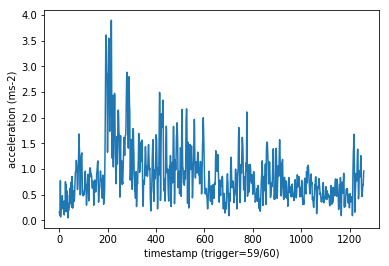

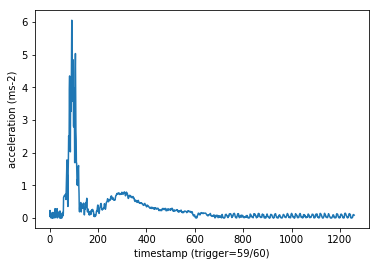

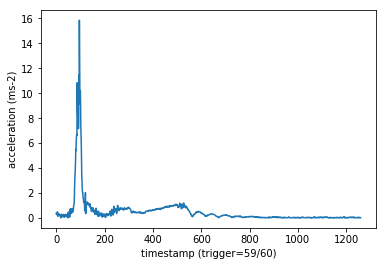

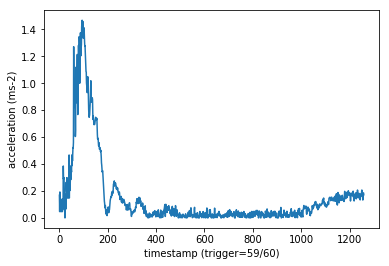

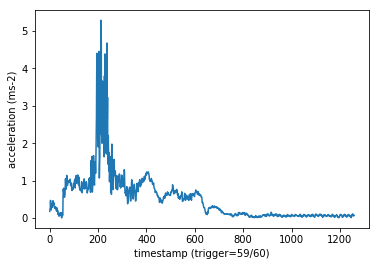

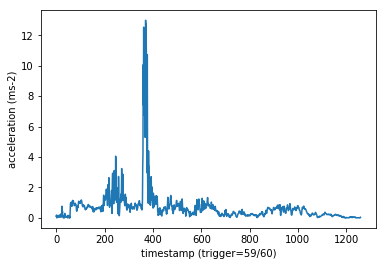

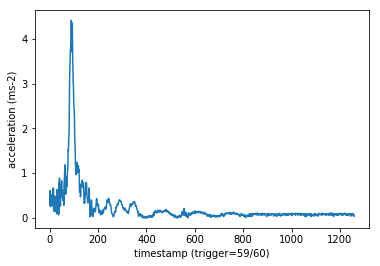

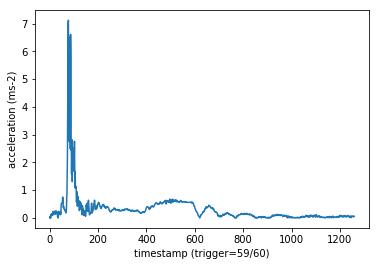

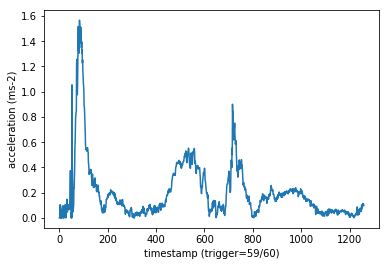

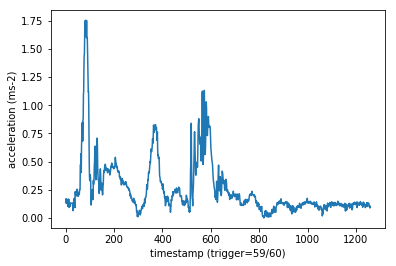

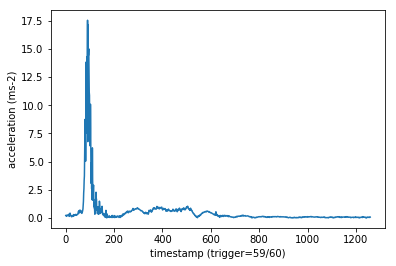

In [64]:
# MODULO ACCELERAZIONE
for a in ACC:
    df = pd.read_csv(a, delimiter=';')
    df['acc'] = np.sqrt(df['accX']**2+df['accY']**2+(df['accZ']-1)**2)
    plt.figure()
    plt.plot(df.acc)
    plt.xlabel('timestamp (trigger=59/60)')
    plt.ylabel('acceleration (ms-2)')

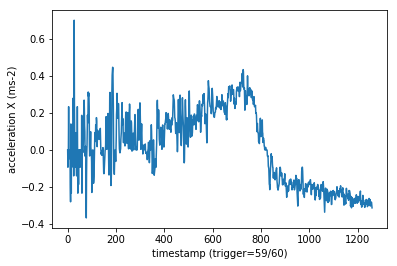

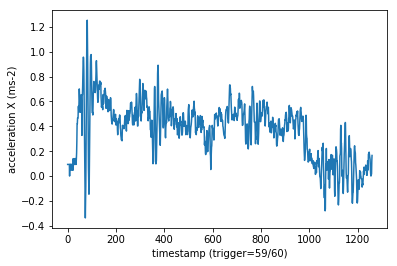

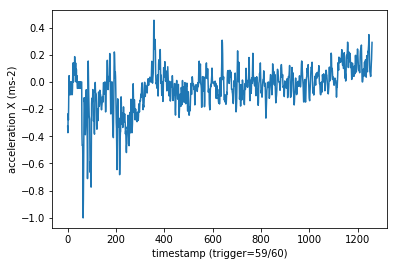

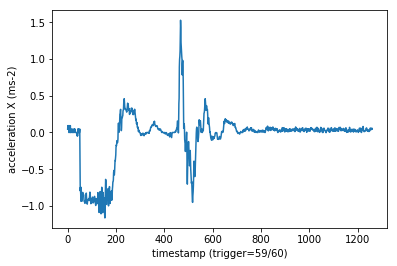

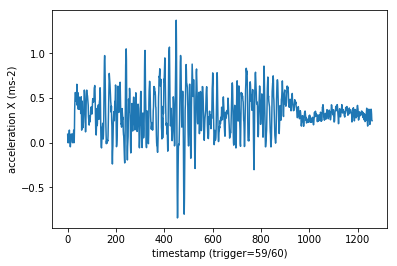

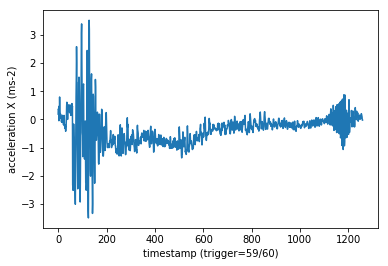

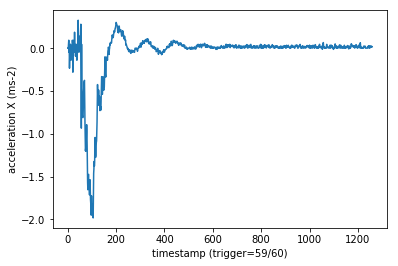

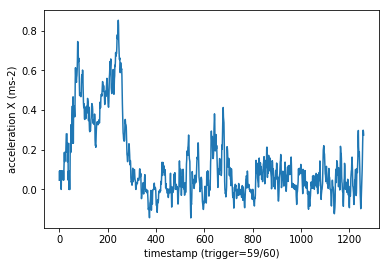

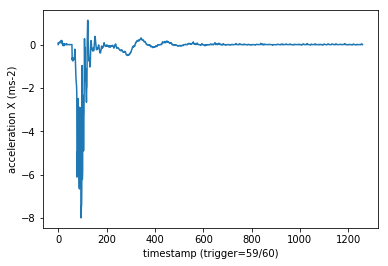

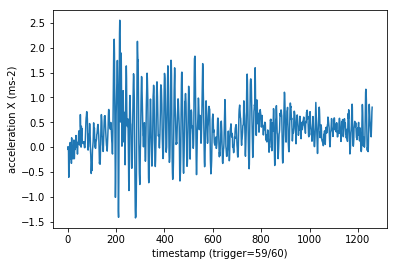

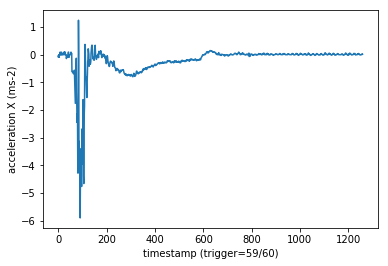

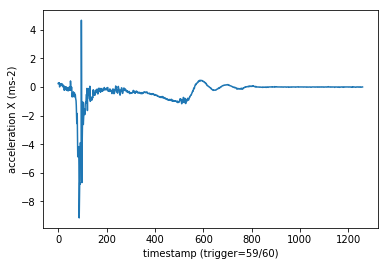

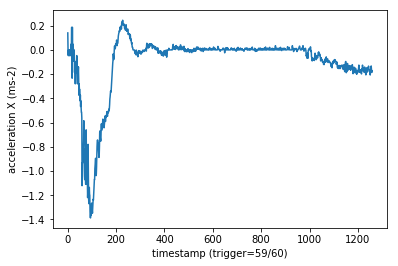

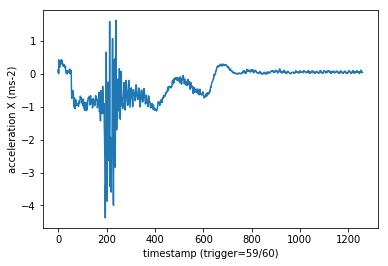

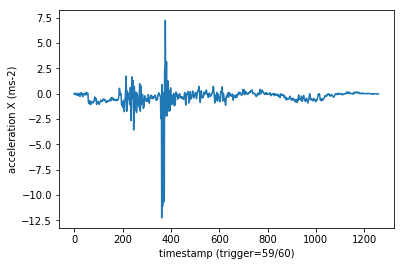

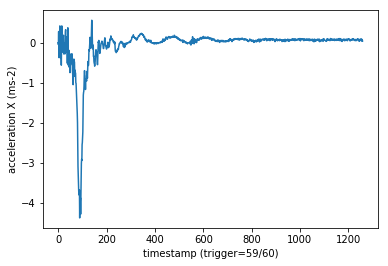

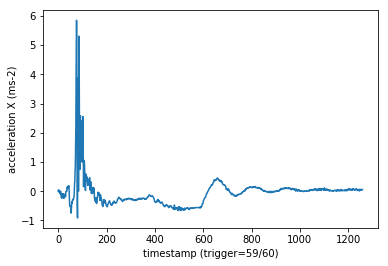

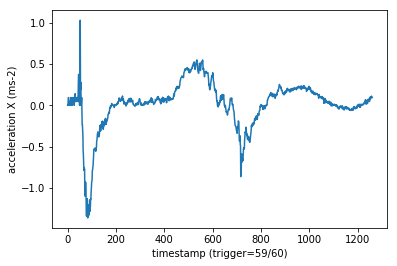

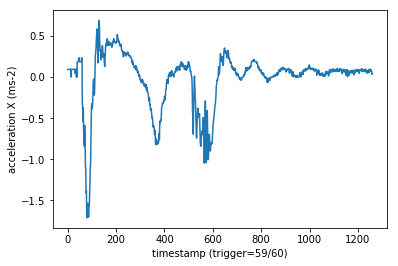

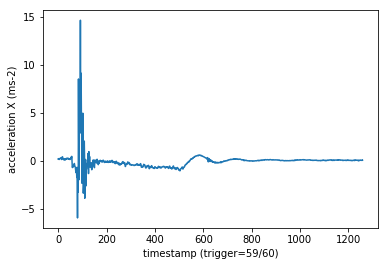

In [65]:
# MODULO ACCELERAZIONE
for a in ACC:
    df = pd.read_csv(a, delimiter=';')
    #df['acc'] = np.sqrt(df['accX']**2+df['accY']**2+(df['accZ']-1)**2)
    plt.figure()
    plt.plot(df.accX)
    plt.xlabel('timestamp (trigger=59/60)')
    plt.ylabel('acceleration X (ms-2)')

### Studio sui sinistri NON abbinati

In [27]:
df_sinistri = pd.read_csv('sinistri_con_voucher_MOD_MANUALE.csv', delimiter=';')

In [28]:
# quanti voucher che hanno effettuato sinistri non ho abbinato?
voucherS = set(df_sinistri['voucherId'].astype('str'))
voucherS_abbinati = set(crashAbbinati['device'].astype('str'))
voucher_crash = set(data['device'].astype('str'))

voucher_non_abbinati = voucherS.difference(voucherS_abbinati)
len(voucher_crash)

502

In [37]:
# quanti crash hanno fatto i voucher che hanno fatto sinistro e che non abbinati?
# quando è stato il primo e ultimo crash?
g = data.groupby('device')
sinistrif = open('sinistri_con_voucher_MOD_MANUALE.csv','r')
sinistri = csv.reader(sinistrif, delimiter=';')
next(sinistri, None)

grouped = data.groupby('device')
sinistri_non_abbinati_list = []

voucher_visti = set()

for row in sinistri:
    datas = row[0]
    oras = row[1]
    luogos = row[3]
    provincias = row[4]
    lats = row[5]
    lons = row[6]
    delta = 0
    timestamp = datas+' '+oras
    date = datetime.strptime(datas,'%Y-%m-%d')
    hour = datetime.strptime(oras,'%H:%M')
    timestamp = datetime.strptime(timestamp,'%Y-%m-%d %H:%M')
    devices = row[2]#.strip('.0')
    #datetime.strptime(gr['timestamp'],'%Y-%m-%d %H:%M')
    #gr['timestamp']
    
    for voucher in voucher_non_abbinati:
        if voucher==devices and voucher not in voucher_visti:
            voucher_visti.add(voucher)
            try:
                gr = grouped.get_group((devices))
                giorni_in_flotta = (datetime.strptime(max(gr['timestamp']),'%Y-%m-%d %H:%M:%S')
                         - datetime.strptime(min(gr['timestamp']),'%Y-%m-%d %H:%M:%S')).days
                lista = [voucher, datas+' '+oras, len(gr), min(gr['timestamp']), max(gr['timestamp']),
                        giorni_in_flotta, len(gr)/giorni_in_flotta]
                #print(lista)
                sinistri_non_abbinati_list.append(lista)
            except Exception as e:
                print(e)
                pass

            
sinistrif.close()
dfSNAc = pd.DataFrame(sinistri_non_abbinati_list, columns=['voucher',
                                                           'timestamp_sinistro',
                                                           'num_crash',
                                                           'min_timestamp_voucher',
                                                           'max_timestamp_voucher',
                                                           'giorni_in_flotta',
                                                           'densita_crash'])
dfSNAc.head(10)

,voucher,timestamp_sinistro,num_crash,min_timestamp_voucher,max_timestamp_voucher,giorni_in_flotta,densita_crash
0,248746,2018-03-11 00:00,127,2018-02-15 04:42:51,2018-10-24 02:12:02,250,0.508000
1,268680,2018-03-18 00:00,68,2018-02-13 22:27:50,2018-10-23 13:52:01,251,0.270916
2,262812,2018-05-05 00:00,48,2018-02-12 21:14:17,2018-10-26 00:52:02,255,0.188235
3,251216,2018-04-19 00:00,142,2018-02-14 07:00:37,2018-10-24 11:12:01,252,0.563492
4,268452,2018-05-30 08:35,900,2018-02-28 12:05:23,2018-10-29 21:07:34,243,3.703704
5,252145,2018-06-12 00:00,1196,2018-02-13 08:16:09,2018-10-28 19:37:33,257,4.653696
6,270002,2018-05-30 00:00,82,2018-02-14 03:48:28,2018-10-26 00:52:02,253,0.324111
7,262816,2018-02-20 00:00,66,2018-02-13 18:38:37,2018-10-28 19:17:33,257,0.256809
8,253195,2018-05-05 00:00,30,2018-02-12 23:05:27,2018-10-26 08:57:01,255,0.117647
9,270372,2018-02-26 00:00,45,2018-02-16 14:26:46,2018-10-13 19:02:03,239,0.188285


In [38]:
# quanti crash hanno fatto i voucher che hanno fatto sinistro e che SONO abbinati?
# quando è stato il primo e ultimo crash?
g = data.groupby('device')
sinistrif = open('sinistri_con_voucher_MOD_MANUALE.csv','r')
sinistri = csv.reader(sinistrif, delimiter=';')
next(sinistri, None)

grouped = data.groupby('device')
sinistri_abbinati_list = []

voucher_inseriti = set()

for row in sinistri:
    datas = row[0]
    oras = row[1]
    luogos = row[3]
    provincias = row[4]
    lats = row[5]
    lons = row[6]
    delta = 0
    timestamp = datas+' '+oras
    date = datetime.strptime(datas,'%Y-%m-%d')
    hour = datetime.strptime(oras,'%H:%M')
    timestamp = datetime.strptime(timestamp,'%Y-%m-%d %H:%M')
    devices = row[2]#.strip('.0')
    
    
    
    for voucher in voucherS_abbinati:
        if voucher==devices and voucher not in voucher_visti:
            voucher_visti.add(voucher)
            try:
                gr = grouped.get_group((voucher))
                giorni_in_flotta = (datetime.strptime(max(gr['timestamp']),'%Y-%m-%d %H:%M:%S')
                         - datetime.strptime(min(gr['timestamp']),'%Y-%m-%d %H:%M:%S')).days
                lista = [voucher, datas+' '+oras, len(gr), min(gr['timestamp']), max(gr['timestamp']),
                        giorni_in_flotta, len(gr)/giorni_in_flotta]
                #print(lista)
                sinistri_abbinati_list.append(lista)
            except Exception as e:
                print(e)
                pass

            
sinistrif.close()
dfSAc = pd.DataFrame(sinistri_abbinati_list, columns=['voucher',
                                                           'timestamp_sinistro',
                                                           'num_crash',
                                                           'min_timestamp_voucher',
                                                           'max_timestamp_voucher',
                                                           'giorni_in_flotta',
                                                           'densita_crash'])
dfSAc.head(10)

,voucher,timestamp_sinistro,num_crash,min_timestamp_voucher,max_timestamp_voucher,giorni_in_flotta,densita_crash
0,265948,2018-03-03 00:00,88,2018-02-13 21:55:37,2018-10-29 05:52:33,257,0.342412
1,263904,2018-03-08 22:45,47,2018-02-15 01:56:14,2018-10-25 18:37:03,252,0.186508
2,269917,2018-03-15 20:38,581,2018-02-13 11:33:12,2018-10-25 19:27:02,254,2.287402
3,253778,2018-03-05 00:00,130,2018-02-13 01:18:38,2018-10-29 04:42:33,258,0.503876
4,265077,2018-03-22 00:00,126,2018-02-14 21:24:11,2018-10-29 03:52:33,256,0.492188
5,268524,2018-04-03 00:00,1069,2018-02-13 07:33:55,2018-10-13 03:02:02,241,4.435685
6,264629,2018-04-09 00:00,1242,2018-02-12 23:14:27,2018-10-28 02:07:34,257,4.832685
7,252147,2018-04-14 00:00,286,2018-02-12 22:58:47,2018-04-14 06:25:04,60,4.766667
8,264628,2018-04-11 00:00,45,2018-02-15 12:19:47,2018-10-19 23:27:01,246,0.182927
9,264721,2018-02-18 06:30,1199,2018-02-12 23:49:48,2018-10-26 16:32:02,255,4.701961


In [40]:
# quanti crash hanno fatto i voucher in generale?
# quando è stato il primo e ultimo crash?
g = data.groupby('device')
grouped = data.groupby('device')


crashes = []

for voucher in voucher_crash:
    try:
        gr = grouped.get_group((voucher))
        giorni_in_flotta = (datetime.strptime(max(gr['timestamp']),'%Y-%m-%d %H:%M:%S')
                 - datetime.strptime(min(gr['timestamp']),'%Y-%m-%d %H:%M:%S')).days
        lista = [voucher, len(gr), min(gr['timestamp']), max(gr['timestamp']),
                giorni_in_flotta, len(gr)/giorni_in_flotta]
        #print(lista)
        crashes.append(lista)
    except Exception as e:
        print((datetime.strptime(max(gr['timestamp']),'%Y-%m-%d %H:%M:%S')
                 - datetime.strptime(min(gr['timestamp']),'%Y-%m-%d %H:%M:%S')))
        print(e)
        pass

dfCrash = pd.DataFrame(crashes, columns=['voucher',        
                                       'num_crash',
                                       'min_timestamp_voucher',
                                       'max_timestamp_voucher',
                                       'giorni_in_flotta',
                                       'densita_crash'])
dfCrash.head(20)

0:00:00
division by zero


,voucher,num_crash,min_timestamp_voucher,max_timestamp_voucher,giorni_in_flotta,densita_crash
0,252148,1540,2018-02-13 22:33:29,2018-10-29 14:12:34,257,5.992218
1,253200,43,2018-02-15 01:50:52,2018-10-28 14:17:34,255,0.168627
2,265753,194,2018-02-15 00:07:47,2018-10-29 03:07:33,256,0.757812
3,264616,244,2018-02-13 02:53:25,2018-10-30 07:52:33,259,0.942085
4,254486,144,2018-02-14 21:32:58,2018-10-22 06:12:01,249,0.578313
5,269033,54,2018-02-18 00:14:39,2018-10-20 20:42:01,244,0.221311
6,263910,47,2018-02-15 03:45:19,2018-10-23 21:12:03,250,0.188000
7,264618,1164,2018-02-12 18:33:13,2018-10-29 22:02:33,259,4.494208
8,269758,1189,2018-02-12 18:53:48,2018-10-30 05:37:35,259,4.590734
9,267642,63,2018-02-20 22:25:59,2018-10-26 21:07:01,247,0.255061


In [377]:
dfSAc.to_excel('sinistri_abbinati.xlsx', index=False)
dfSNAc.to_excel('sinistri_non_abbinati.xlsx', index=False)

In [39]:
print('media crash device:',np.mean(dfCrash['num_crash']))
print('media crash device con nessun sinistro abbinato:',np.mean(dfSNAc['num_crash']))
print('media crash device con almeno 1 sinistro abbinato:',np.mean(dfSAc['num_crash']))
print()

print('max crash device:',max(dfCrash['num_crash']))
print('max crash device con nessun sinistro abbinato:',max(dfSNAc['num_crash']))
print('max crash device con almeno 1 sinistro abbinato:',max(dfSAc['num_crash']))
print()

print('min crash device:',min(dfCrash['num_crash']))
print('min crash device con nessun sinistro abbinato:',min(dfSNAc['num_crash']))
print('min crash device con almeno 1 sinistro abbinato:',min(dfSAc['num_crash']))
print()

print('media giorni in flotta:',np.mean(dfCrash['giorni_in_flotta']))
print('media giorni in flotta device con nessun sinistro abbinato:',np.mean(dfSNAc['giorni_in_flotta']))
print('media giorni in flotta device con almeno 1 sinistro abbinato:',np.mean(dfSAc['giorni_in_flotta']))
print()

print('media densità temporale crash:',np.mean(dfCrash['densita_crash']))
print('media densità temporale crash device con nessun sinistro abbinato:',np.mean(dfSNAc['densita_crash']))
print('media densità temporale device con almeno 1 sinistro abbinato:',np.mean(dfSAc['densita_crash']))

media crash device: 374.8183632734531
media crash device con nessun sinistro abbinato: 305.7042253521127
media crash device con almeno 1 sinistro abbinato: 467.86746987951807

max crash device: 5528
max crash device con nessun sinistro abbinato: 1540
max crash device con almeno 1 sinistro abbinato: 1798

min crash device: 4
min crash device con nessun sinistro abbinato: 11
min crash device con almeno 1 sinistro abbinato: 20

media giorni in flotta: 244.24550898203591
media giorni in flotta device con nessun sinistro abbinato: 243.09859154929578
media giorni in flotta device con almeno 1 sinistro abbinato: 241.67469879518072

media densità temporale crash: 1.4988774918218435
media densità temporale crash device con nessun sinistro abbinato: 1.231411589031488
media densità temporale device con almeno 1 sinistro abbinato: 1.9038344735290822


In [379]:
# quanti crash hanno fatto i voucher che hanno fatto sinistro e che non sono abbinati
# nelle due settimane attorno al sinistro?
g = data.groupby('device')
sinistrif = open('sinistri_con_voucher_MOD_MANUALE.csv','r')
sinistri = csv.reader(sinistrif, delimiter=';')
next(sinistri, None)

grouped = data.groupby('device')
sinistri_non_abbinati_list = []
voucher_visti = set()

for row in sinistri:
    datas = row[0]
    oras = row[1]
    luogos = row[3]
    provincias = row[4]
    lats = row[5]
    lons = row[6]
    delta = 0
    timestamp = datas+' '+oras
    date = datetime.strptime(datas,'%Y-%m-%d')
    hour = datetime.strptime(oras,'%H:%M')
    timestamp = datetime.strptime(timestamp,'%Y-%m-%d %H:%M')
    devices = row[2]#.strip('.0')
    
    for voucher in voucher_non_abbinati:
        if voucher==devices and voucher not in voucher_visti:
            voucher_visti.add(voucher)
            try:
                gr = grouped.get_group((devices))
                n = 0
                for date in gr['timestamp']:
                    diff = np.abs(datetime.strptime(date,'%Y-%m-%d %H:%M:%S')-timestamp)
                    if diff<=timedelta(days=1):
                        n += 1
                lista = [voucher, datas+' '+oras, n]
                #print(lista)
                sinistri_non_abbinati_list.append(lista)
            except Exception as e:
                print(e)
                lista = [voucher, datas+' '+oras, 0]
                #print(lista)
                sinistri_non_abbinati_list.append(lista )

            
sinistrif.close()
dfSNAc1set = pd.DataFrame(sinistri_non_abbinati_list, columns=['voucher','timestamp_sinistro','num_crash'])
dfSNAc1set.head(10)

,voucher,timestamp_sinistro,num_crash
0,248746,2018-03-11 00:00,0
1,268680,2018-03-18 00:00,1
2,262812,2018-05-05 00:00,0
3,251216,2018-04-19 00:00,0
4,268452,2018-05-30 08:35,0
5,252145,2018-06-12 00:00,0
6,270002,2018-05-30 00:00,0
7,262816,2018-02-20 00:00,0
8,253195,2018-05-05 00:00,0
9,270372,2018-02-26 00:00,0


In [380]:
[e for e in list(dfSNAc1set['num_crash']) if e!=0]

[1, 1, 1, 1, 2, 5, 8, 12, 1, 6]

In [381]:
len([e for e in list(dfSNAc1set['num_crash']) if e==0])

61

In [78]:
l

['2018',
 '10',
 '30',
 '15',
 '22',
 '35',
 '57960944',
 'INFOMOBILITY248440',
 '417',
 'POS.csv']

In [84]:
len(data)

182424

In [82]:
errors[0]

TypeError('join() takes exactly one argument (3 given)')

In [ ]:
from pykalman import KalmanFilter

def reverse_kalman(dataframe):
   # data = dataframe.copy()
    data = dataframe.iloc[::-1].reset_index()
    del data['index']
    data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
    data['timestamp'] = data['datetime'].apply(lambda x: x.strftime('%S.%f'))
    data['timestamp'] = data['datetime'].apply(lambda x: float(x.timestamp()))
    #data['timestamp'] = pd.to_numeric(data['datetime'])
    #data['timestamp'] = data['timestamp'].apply(lambda x: -x)
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=2)
    
    return data

def AccCleaner(dataframe, col, th):
    dataframe = dataframe.apply(lambda r: 0 if r[col]>th else r[col], axis=1)
    return dataframe


In [38]:

sinistrif = open('sinistri_con_voucher_MOD_MANUALE.csv','r')
sinistri = csv.reader(sinistrif, delimiter=';')
next(sinistri, None)

grouped = data.groupby(['device','data'])

n_crash = []
mancanti = 0
ora_crash = []

crashAbbinati_test_list = []
crashAbbinati_test = pd.DataFrame()

for row in sinistri:
    datas = row[0]
    oras = row[1]
    luogos = row[3]
    provincias = row[4]
    lats = row[5]
    lons = row[6]
    delta = 0
    timestamp = datas+' '+oras
    date = datetime.strptime(datas,'%Y-%m-%d')
    hour = datetime.strptime(oras,'%H:%M')
    timestamp = datetime.strptime(timestamp,'%Y-%m-%d %H:%M')
    devices = row[2]#.strip('.0')
    #if date < datetime.strptime('2018-08-01','%Y-%m-%d'):
    #    print('saltata la data:', datas)
    #    continue
    tipo = 'piu_alto'
    try:
        g = grouped.get_group((devices,datas))
        filesAcc = list(g['fileACC'])
        filesPos = list(g['filePOS'])
        timestamp_crash = list(g['timestamp'])
        #if len(filesAcc) == 1:  # se c'è un solo crash, abbina quello
        #    oracrash = g['ora'].values[0][0:8]
        #    df = pd.read_csv(filesPos[0], delimiter=';')
        #    latc, lonc = finderLatLon(df)
        #    crashAbbinati_list.append([devices, datas, oras, luogos, provincias, lats, lons,
        #                                                                oracrash, filesPos[0], filesAcc[0],
        #                                                                latc, lonc,
        #                                                                'unicoCrash'])
        #    print('Abbinato (unico crash):', datas, oras, devices)
        #else:  # se ci sono più crash
            #g['ora'] = pd.to_datetime(g['ora'],format='%H:%M:%S')  # converte a datetime
            #piu_vicino = (g['ora']-hour).abs().argsort()[:1].index.tolist()[0]  # trova indice di crash più vicino
            #ora_piu_vicino_str = data.iloc[piu_vicino]['ora']  # trova ora di crash più vicino
            #ora_piu_vicino = datetime.strptime(ora_piu_vicino_str,'%H:%M:%S')  # converte in datetime
            # calcola la differenza tra ora crash e ora ora sinistro
            #diff_crash_sinistro_abs = max(ora_piu_vicino,hour)-min(ora_piu_vicino,hour)
        if oras != '00:00':
            filesAcc_4ore = []
            filesPos_4ore = []

            for acc,pos,time in zip(filesAcc,filesPos,timestamp_crash):
                diff = np.abs(datetime.strptime(time,'%Y-%m-%d %H:%M:%S')-timestamp)
                #print(diff, type(diff))
                if diff<=timedelta(seconds=7200):
                    filesAcc_4ore.append(acc)
                    filesPos_4ore.append(pos)
            if len(filesAcc_4ore)!=0:
                filesAcc = filesAcc_4ore
                filesPos = filesPos_4ore
                tipo = 'intorno4ore'
                print('Abbinamento: intorno 4 ore')
            #if oras != '00:00' and diff_crash_sinistro_abs<=timedelta(seconds=7200):  # se c'è l'ora del sinistro
            #                                                                           # e ora_sin-ora_cr <= 4h
            #    df = pd.read_csv(data.iloc[piu_vicino]['filePOS'], delimiter=';')
            #    latc, lonc = finderLatLon(df)
            #    crashAbbinati_list.append([devices, datas, oras, luogos, provincias, lats, lons,
            #                                                     ora_piu_vicino_str.rstrip('.0000'),
            #                                                     data.iloc[piu_vicino]['filePOS'],
            #                                                     data.iloc[piu_vicino]['fileACC'],
            #                                                     latc, lonc,
            #                                                     'intorno4ore'])
            #    print('Abbinato (più vicino in 4 ore)', datas, oras, devices)
        #else:  # se non c'è ora sinistro o ora_sin-ora_cr >= 4h
        accelerations = []
        max_idxs = []
        for file in filesAcc:
            a = pd.read_csv(file, delimiter=';')
            a['acc'] = np.sqrt(a['accX']**2+a['accY']**2+(a['accZ']-1)**2)
            #a['acc'] = AccCleaner(a, 'acc', 30)
            #accelerations.append(a['accX']**2+a['accY']**2)
            #if max(list(a['acc']))<23:
            accelerations.append(max(list(a['acc'])))
            max_idxs.append(list(a['acc']).index(max(list(a['acc']))))
            #idx_a = list(a['acc']).index(max(list(a['acc'])))
            #else:
            #accelerations.append(0)
            #accelerations.append(max(a['accX'],a['accY'],a['accZ']-1))
            #accelerations.append(max(a['accX'],a['accY'],a['accZ']-1))
        idx = accelerations.index(max(accelerations))
        oracrash = pd.read_csv(filesAcc[idx],delimiter=';').iloc[61]['datetime'][11:19]
        df = pd.read_csv(filesPos[idx], delimiter=';')
        latc, lonc = finderLatLon(df)

        crashAbbinati_test_list.append([devices, datas, oras, luogos, provincias, lats, lons,
                                                                        oracrash,
                                                                        filesPos[idx], filesAcc[idx],
                                                                        latc, lonc,
                                                                        tipo, max(accelerations)])
        print('Abbinato', tipo, datas, oras, devices)
        n_crash.append(g['periodo'].count())
        #ora_crash.append(oras)
        
    except Exception as e:
        print('    No crash per sinistro:', datas, devices, e)
        mancanti += 1
        
crashAbbinati_test = pd.DataFrame(crashAbbinati_test_list, columns=['device', 'dataSinistro', 'oraSinistro', 
                                                          'luogoSinistro', 'provinciaSinistro',
                                                          'latSinistro', 'lonSinistro',
                                                          'oraCrash',
                                                          'filePOS', 'fileACC',
                                                          'latCrash', 'lonCrash',
                                                          'tipoAbbinamento','max_ACC'
                                                         ])
#plt.hist(n_crash)

sinistrif.close()

crashAbbinati_test['distanza_km'] = crashAbbinati_test.apply(lambda r:
                                        earth_distance((r['latSinistro'],
                                                        r['lonSinistro']),
                                                       (r['latCrash'],
                                                        r['lonCrash']))          
                                                  , axis=1)


Abbinato piu_alto 2018-03-03 00:00 265948
    No crash per sinistro: 2018-03-11 248746 ('248746', '2018-03-11')
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-08 22:45 263904
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-15 20:38 269917
Abbinato piu_alto 2018-03-05 00:00 253778
Abbinato piu_alto 2018-03-22 00:00 265077
Abbinato piu_alto 2018-04-03 00:00 268524
Abbinato piu_alto 2018-04-09 00:00 264629
    No crash per sinistro: 2018-03-18 268680 ('268680', '2018-03-18')
Abbinato piu_alto 2018-04-14 00:00 252147
    No crash per sinistro: 2018-05-05 262812 ('262812', '2018-05-05')
    No crash per sinistro: 2018-04-04 265948 ('265948', '2018-04-04')
    No crash per sinistro: 2018-04-19 251216 ('251216', '2018-04-19')
Abbinato piu_alto 2018-04-11 00:00 264628
    No crash per sinistro: 2018-05-30 268452 ('268452', '2018-05-30')
    No crash per sinistro: 2018-06-12 252145 ('252145', '2018-06-12')
    No crash per sinistro: 2018-05-30 270002 ('270002', '2018-05-30')
  

Abbinato piu_alto 2018-10-13 00:00 269345
Abbinato piu_alto 2018-09-17 00:00 252146
Abbinato piu_alto 2018-05-01 00:00 266227
    No crash per sinistro: 2018-10-19 265469 ('265469', '2018-10-19')
    No crash per sinistro: 2018-09-27 269913 ('269913', '2018-09-27')
Abbinato piu_alto 2018-10-23 00:00 264718
Abbinato piu_alto 2018-10-20 00:00 264606
    No crash per sinistro: 2018-10-21 270372 ('270372', '2018-10-21')
    No crash per sinistro: 2018-10-18 267093 ('267093', '2018-10-18')
Abbinato piu_alto 2018-10-27 00:00 257288
    No crash per sinistro: 2018-10-23 270034 ('270034', '2018-10-23')
Abbinato piu_alto 2018-10-24 00:00 252156
    No crash per sinistro: 2018-02-13 275296 ('275296', '2018-02-13')
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-09 11:50 270030
    No crash per sinistro: 2018-03-02 269349 ('269349', '2018-03-02')
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-17 15:35 248199
Abbinamento: intorno 4 ore
Abbinato intorno4ore 2018-03-02 08:20 264520


In [39]:
crashAbbinati_test.head()

,device,dataSinistro,oraSinistro,luogoSinistro,provinciaSinistro,latSinistro,lonSinistro,oraCrash,filePOS,fileACC,latCrash,lonCrash,tipoAbbinamento,max_ACC,distanza_km
0,265948,2018-03-03,00:00,VIALE FILARETI 29,MI,45.5691005,8.9530162,18:49:52,D:\Master\Blob2csv\POS\2018_03_03 18_49_52_361...,D:\Master\Blob2csv\ACC\2018_03_03 18_49_52_361...,45.45188,9.19960,piu_alto,19.284934,23.218392
1,263904,2018-03-08,22:45,VIA NOVARA,MI,45.46937,9.12573,21:32:59,D:\Master\Blob2csv\POS\2018_03_08 21_32_59_366...,D:\Master\Blob2csv\ACC\2018_03_08 21_32_59_366...,45.46914,9.12596,intorno4ore,1.752956,0.031237
2,269917,2018-03-15,20:38,CORSO LODI,MI,45.4428,9.21824,19:36:16,D:\Master\Blob2csv\POS\2018_03_15 19_36_16_372...,D:\Master\Blob2csv\ACC\2018_03_15 19_36_16_372...,45.44071,9.22290,intorno4ore,8.064732,0.431495
3,253778,2018-03-05,00:00,VIA PADOVA 115,MI,45.49704,9.23116,09:05:07,D:\Master\Blob2csv\POS\2018_03_05 09_05_07.000...,D:\Master\Blob2csv\ACC\2018_03_05 09_05_07.000...,45.50531,9.23774,piu_alto,2.174965,1.052909
4,265077,2018-03-22,00:00,V.LE E FERMI,MI,45.51515,9.17911,08:54:06,D:\Master\Blob2csv\POS\2018_03_22 08_54_06_377...,D:\Master\Blob2csv\ACC\2018_03_22 08_54_06_377...,45.51652,9.17860,piu_alto,12.409111,0.157435


In [40]:
crashAbbinati_test.to_excel('_TEST_sinistri2crash_MOD_MANUALE.xlsx', index=False)